## Making a Potential Energy Curve of an I$^-$-H$_2$O dimer
And comparing it to the ASE potential.


Imports:

In [1]:
import numpy as np
import sys, matplotlib
sys.path.append('../../')

%matplotlib widget
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.autolayout': True})

from cmm.tools.ase_openmm import OpenMMCalc
from cmm.tools.tip4pew import angleHOH, rOH, TIP4PEW
from cmm.tools.tip4pew import TIP4PEW, sigma0 as sig_ew, epsilon0 as eps_ew

import ase.units as ase_u
from ase import Atoms
from ase.calculators.tip4p import TIP4P, sigma0, epsilon0
from ase.calculators.combine_mm import CombineMM
from ase.calculators.counterions import AtomicCounterIon as ACI

from openmm import unit as u
from openmm import openmm as mm
from openmm.openmm import NonbondedForce

import nglview as nv

Define helper functions

In [2]:
def make_ase_atoms(sig, eps, r, chrg=-1, calc2=TIP4PEW, sig2=sigma0, eps2=epsilon0):
    ''' Setup the dimer and the ASE calculator '''
    x = angleHOH * np.pi / 180 / 2
    pos = [[0, r, 0],
           [0, 0, 0],
           [0, rOH * np.cos(x), rOH * np.sin(x)],
           [0, rOH * np.cos(x), -rOH * np.sin(x)]]
    atoms = Atoms('IOH2', positions=pos)
    calc = CombineMM([0], apm1=1, apm2=3,  
                     calc1=ACI(chrg, eps, sig),  
                     calc2=calc2(),  
                     sig1=[sig], eps1=[eps], 
                     sig2=np.array([sig2, 0, 0]), eps2=np.array([eps2, 0, 0]),
                     rc=100) 
    atoms.calc = calc
    return atoms

def make_omm_atoms(r=3):
    ''' Make OpenMM atoms object, it needs the virtual charge site exposed'''
    x = angleHOH * np.pi / 180 / 2
    pos = [[0, r, 0],
           [0, 0, 0],
           [0, rOH * np.cos(x), rOH * np.sin(x)],
           [0, rOH * np.cos(x), -rOH * np.sin(x)]]

    tip4 = TIP4PEW().add_virtual_sites(np.array(pos[1:]))
    pos = np.vstack((pos[0], tip4))
    atoms = Atoms('IOH2He', positions=pos)
    return atoms

def get_lj(atoms, idx):
    ''' Get LJ parameters from OpenMM '''
    sigma = np.nan
    epsilon = np.nan
    for force in atoms.calc.sys.getForces():
        if isinstance(force, NonbondedForce):
            for i in range(force.getNumParticles()):
                if i == idx:
                    charge, sigma, epsilon = force.getParticleParameters(i)
                    sigma = sigma.in_units_of(u.angstrom)._value
                    epsilon = epsilon.in_units_of(u.kilojoule_per_mole)._value * ase_u.kJ / ase_u.mol

    return sigma, epsilon



Test that ASE and OpenMM gives the same results

(3.16435, 0.007057507909821547)


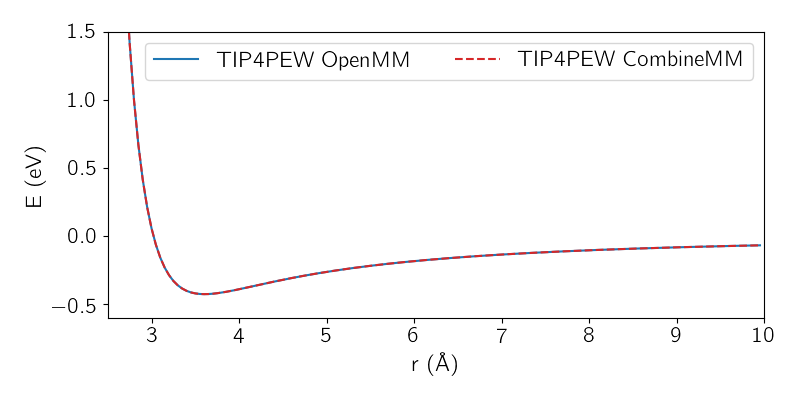

In [3]:
rs = np.arange(1.5, 10, 0.05)
omm_ener = np.zeros(len(rs))
ase_ener = np.zeros(len(rs))

pes_traj = []

for i, r in enumerate(rs):
    # Get OpenMM Energies:
    omm_atoms = make_omm_atoms(r)
    calc = OpenMMCalc([['I'], ['HOH', 'HOH', 'HOH', 'HOH']])  # 'HOH' is the resname for each atom
    calc.make_topology(omm_atoms)
    omm_atoms.calc = calc
    omm_ener[i] = omm_atoms.get_potential_energy()
    
    pes_traj.append(omm_atoms)
    
    # Get ASE energies
    if i == 0: 
        sigma, epsilon = get_lj(omm_atoms, 0)
        print(get_lj(omm_atoms, 1))
    
    ase_atoms = make_ase_atoms(sigma, epsilon, r, calc2=TIP4PEW, sig2=sig_ew, eps2=eps_ew)
    ase_ener[i] = ase_atoms.get_potential_energy()



fig, ax = plt.subplots(1, 1, figsize=(8, 4));
ax.plot(rs, omm_ener, label='TIP4PEW OpenMM')
ax.plot(rs, ase_ener, '--', color=f'C{3}', label='TIP4PEW' + ' CombineMM' )

ax.set_ylim([-0.6, 1.5])
ax.set_xlim([2.5, 10])
ax.legend(loc='best', ncol=2)
ax.set_xlabel('r (Å)')
ax.set_ylabel('E (eV)');

View the scanned frames (requires nglview)

In [4]:
from ase.visualize import view
view(pes_traj, viewer='ngl')

### Potential Curves for Verena's manuscript

Create a dimer with a similar orientation as the first waters in the shell of I-

In [5]:
def make_omm_atoms(r=3):
    ''' Make OpenMM atoms object, it needs the virtual charge site exposed'''
    x = angleHOH * np.pi / 180 / 2
    pos = [[0, r, 0],
           [0, 0, 0],
           [0, rOH * np.cos(x), rOH * np.sin(x)],
           [0, rOH * np.cos(x), -rOH * np.sin(x)]]

    tip4 = TIP4PEW().add_virtual_sites(np.array(pos[1:]))
    pos = np.vstack((pos[0], tip4))
    atoms = Atoms('IOH2He', positions=pos)
    water = atoms[1:]
    water.rotate(40.5, 'x')  # adjusted manually according to the next cells
    atoms = Atoms('IOH2He', positions=np.vstack((atoms[0].position, water.positions)))
    atoms.rotate(90, 'y')
    atoms.rotate(90, 'z')  # just for simpler viz.
    return atoms

Make sure the angle for the dimer is the most expressed angle in the MD simulations.

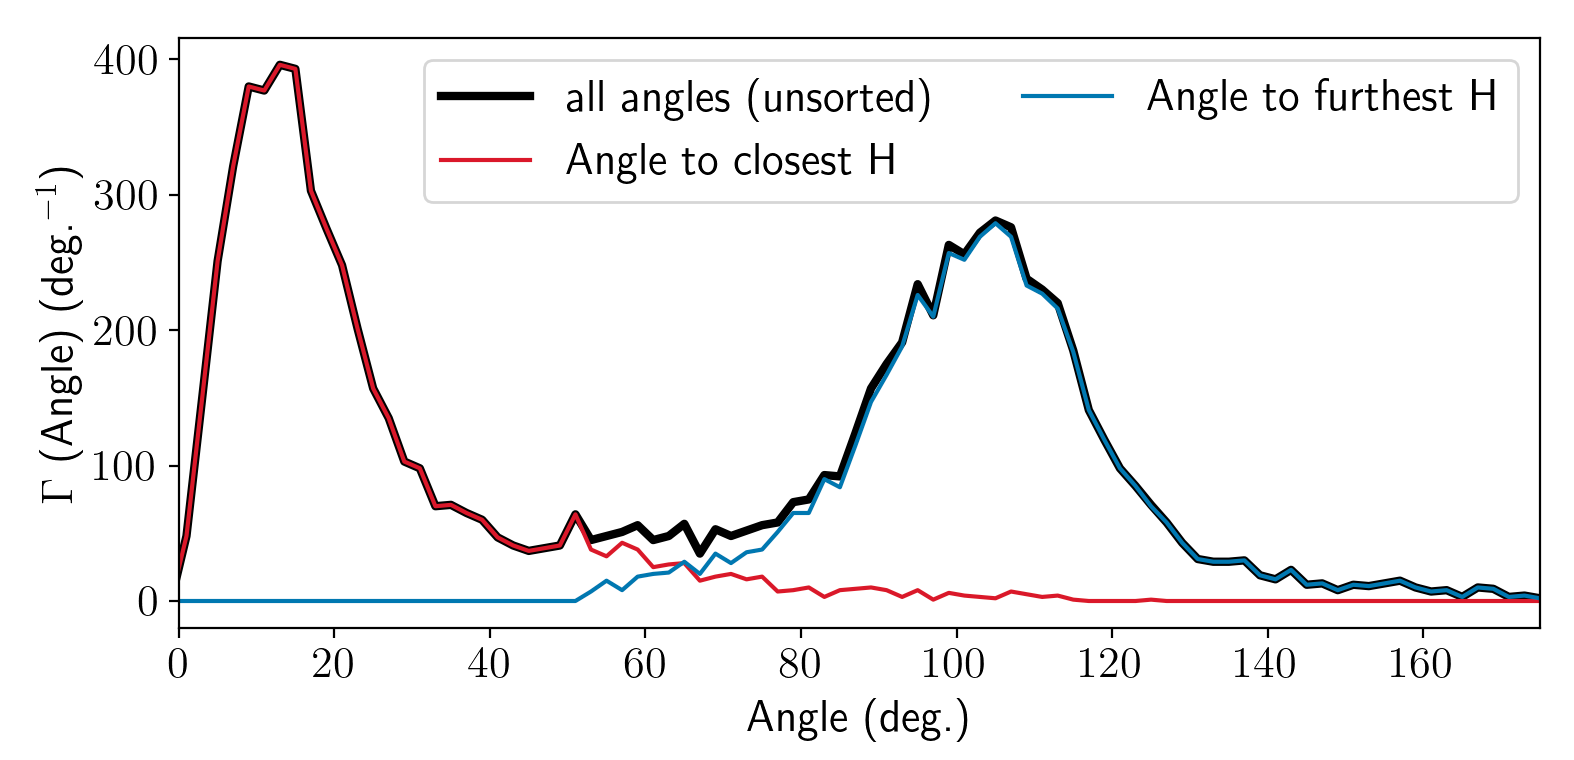

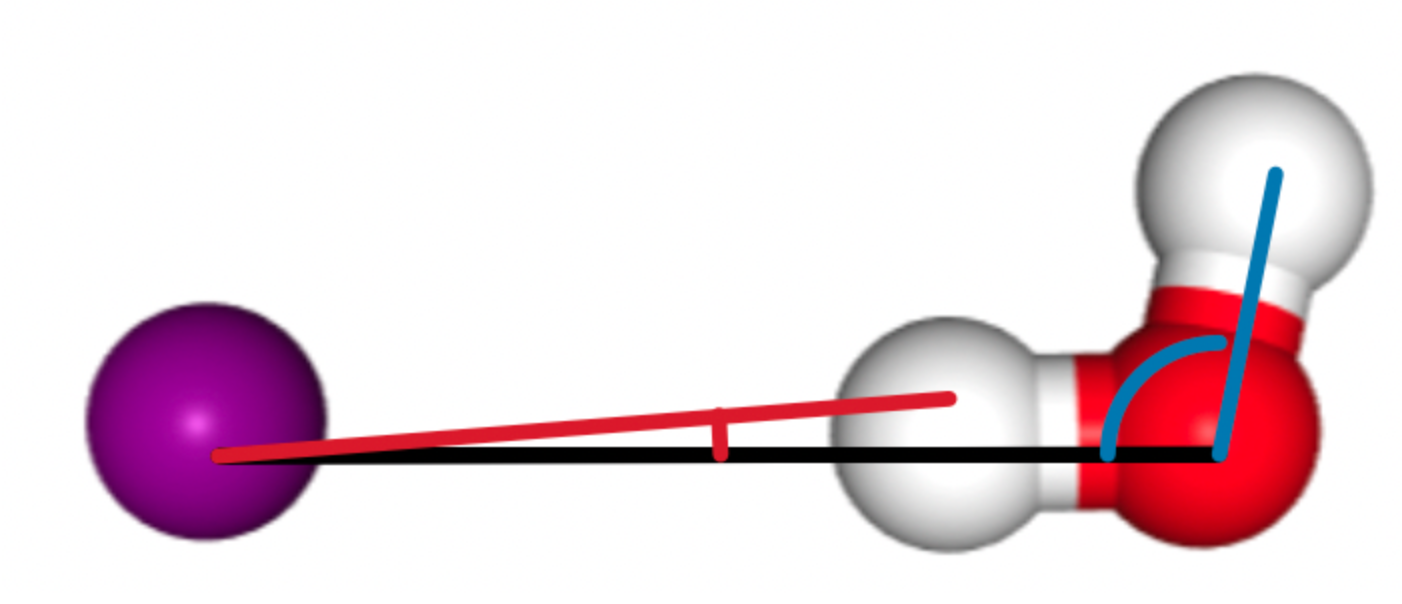

The angle we're after is ~12 deg.


See https://gitlab.com/asod/i-water-angles/-/blob/main/angle_analysis.ipynb 

In [49]:
def get_angles(atoms):
    ''' Get all I-OH angles, 2 per I-Water pair. 
        Also (!) save both of the IH distances 
        (could be interesting later) 
        
        Assumes IOHHIOHHIOHH... sequence. As made by the Sheller
    '''
    # Remove virtual site again
    atoms = Atoms([atom for atom in atoms if atom.symbol != 'He'])

    o_idx = list(range(1, len(atoms), 3))
    
    all_angs = np.zeros((len(o_idx), 2))
    all_dsts = np.zeros((len(o_idx), 2))
    
    for i, o in enumerate(o_idx):
        angs = [atoms.get_angle(0, o, o + i) for i in range(1, 3)]
        dsts = atoms.get_distances(0, [o + 1, o + 2])
        
        all_angs[i, :] = angs
        all_dsts[i, :] = dsts
        
    return all_angs, all_dsts


In [50]:
atoms = make_omm_atoms()
get_angles(atoms)  
# the second set of values is the distances, so we should go for the angle associated with the closest H.

(array([[52.26, 52.26]]), array([[2.53000755, 2.53000755]]))

11.76 degrees, that's pretty much the most expressed angle in the MD sims

In [51]:
atoms

Atoms(symbols='IOH2He', pbc=False)

In [52]:
nv.show_ase(atoms[:-1])

NGLWidget()

Get potential curves

In [53]:
rs = np.arange(1.5, 10, 0.05)
omm_ener = np.zeros((len(rs), 3))

params = {'I-':    {'sig':5.02 * u.angstrom, 'eps':3.69 * u.kilojoule_per_mole, 'charge':-1 * u.elementary_charge},
          'weak':  {'sig':3.75 * u.angstrom, 'eps':2.51 * u.kilojoule_per_mole, 'charge':0 * u.elementary_charge},
          'equal': {'sig':5.02 * u.angstrom, 'eps':3.69 * u.kilojoule_per_mole, 'charge':0 * u.elementary_charge}}

for j, (pset, param) in enumerate(params.items()):
    pes_traj = []
    for i, r in enumerate(rs):
        # Get OpenMM Energies:
        omm_atoms = make_omm_atoms(r)
        calc = OpenMMCalc([['I'], ['HOH', 'HOH', 'HOH', 'HOH']])  # 'HOH' is the resname for each atom
        calc.make_topology(omm_atoms)
        calc.init_system()
        calc.set_nonbonded(idx=0, **param)
        omm_atoms.calc = calc
        omm_ener[i, j] = omm_atoms.get_potential_energy()

        pes_traj.append(omm_atoms)
        if i == 0:
            print(omm_atoms.get_potential_energy())

11140.606538695965
1209.6119536229685
11142.143944291227


plot

/tmp/ipykernel_2174341/3353633947.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('LJ.pdf', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2174341/3353633947.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('LJ.eps', dpi=300)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Text(0.5, 34.26519468010588, '$r_\\mathrm{IO}$ (Å)')

/home/asod/anaconda3/envs/clean/lib/python3.9/site-packages/ipympl/backend_nbagg.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.figure.savefig(buf, format='png', dpi='figure')


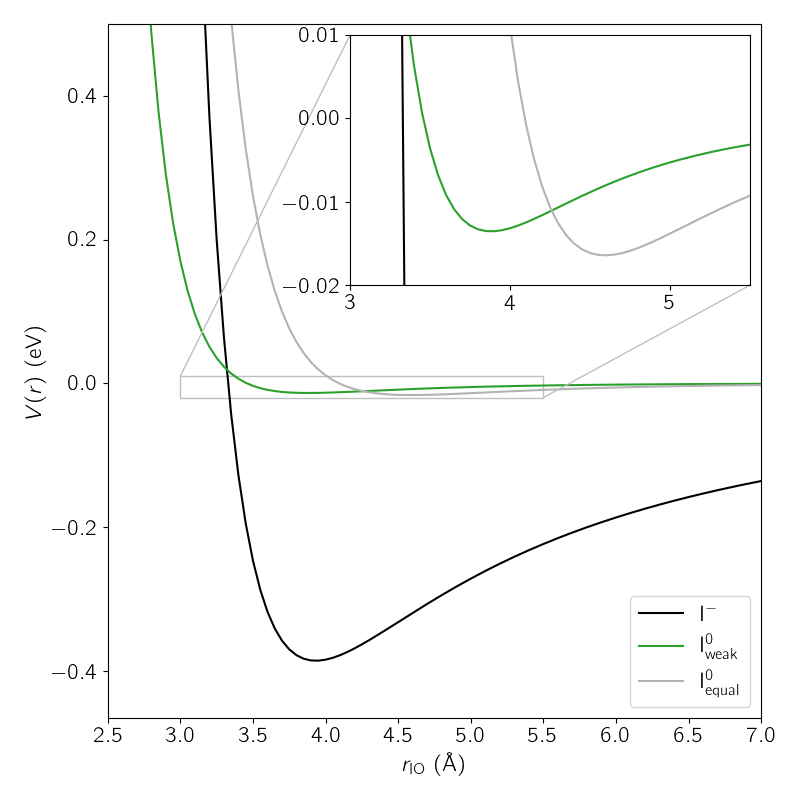

In [54]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset


fig, ax = plt.subplots(1, 1, figsize=(8, 8));
labels = ['I$^{-}$', 'I$^{0}_\mathrm{weak}$', 'I$^{0}_\mathrm{equal}$']
cols = ['k', 'C2', '0.7']
for i, lab in enumerate(labels):
    ax.plot(rs, omm_ener[:, i], label=lab, color=cols[i])

ax.set_ylim([-0.466, 0.5])
ax.set_xlim([2.5, 7])
ax.legend(loc='lower right', ncol=1)
ax.set_xlabel('r (Å)')
ax.set_ylabel('E (eV)');

### Zoomed inset
ax_zoom = inset_axes(ax, width=4, height=2.5,  loc='upper right')
ax_zoom.set_yticks([-2e-2, -1e-2, 0, 1e-2])
ax_zoom.set_xticks([3, 4, 5])

for i, lab in enumerate(labels):
    ax_zoom.plot(rs, omm_ener[:, i], label=lab, color=cols[i])
ax_zoom.set_ylim([-2e-2, 1e-2])
ax_zoom.set_xlim([3.00, 5.5])
mark_inset(ax, ax_zoom, loc1=2, loc2=4, fc="none", ec="0.75")
fig.savefig('LJ.pdf', dpi=300, bbox_inches='tight')
fig.savefig('LJ.eps', dpi=300)
ax.set_ylabel('$V(r)$ (eV)')
ax.set_xlabel('$r_\mathrm{IO}$ (Å)')

In [55]:
view(pes_traj, viewer='ngl')

In [56]:
from ase.io import write
write('pes.xyz', pes_traj, plain=True)

Save the data for Verena to plot

In [187]:
np.savetxt('data.csv', np.vstack((rs, omm_ener.T)).T, delimiter=",", 
           header='r,'+','.join([key for key in params.keys()]))

3.4571750000000003 3.880547731863957
4.092175 4.593311132540409


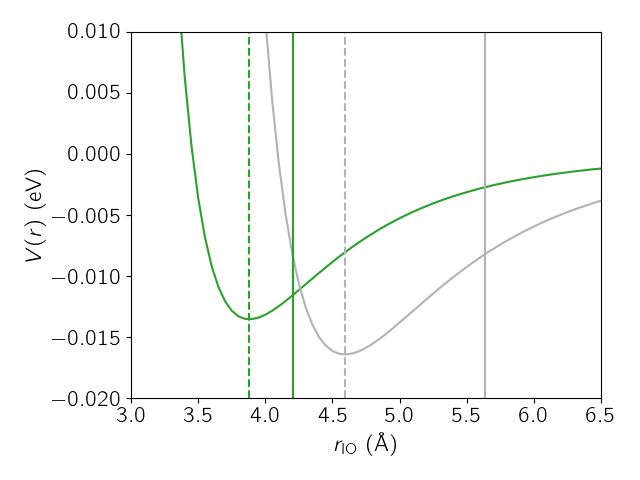

In [61]:

fig, ax_zoom = plt.subplots(1, 1)
#ax_zoom.set_yticks([-2e-2, -1e-2, 0, 1e-2])
#ax_zoom.set_xticks([3, 4, 5])

for i, lab in enumerate(labels):
    if i > 0:
        ax_zoom.plot(rs, omm_ener[:, i], label=lab, color=cols[i])
ax_zoom.set_ylim([-2e-2, 1e-2])
ax_zoom.set_xlim([3.00, 6.5])
#mark_inset(ax, ax_zoom, loc1=2, loc2=4, fc="none", ec="0.75")
ax_zoom.set_ylabel('$V(r)$ (eV)')
ax_zoom.set_xlabel('$r_\mathrm{IO}$ (Å)')
for i, (key, val) in enumerate(params.items()):
    if i > 0:
        ax_zoom.axvline(val['sig']._value * 2**(1/6), color=cols[i])
        comb = (val['sig']._value + 3.16435) / 2
        ax_zoom.axvline(comb * 2**(1/6), color=cols[i], ls='--')
        print(comb, comb * 2**(1/6))